# Trend Following Principal Components Backtest Analysis

## Pacakges

In [90]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from BacktestReturns import Backtest
from TreasuryDataCollect import TreasuryDataCollect

Trying to find data
Found Data



## Data Prep & Signal Prep

In [91]:
df = Backtest().implied_signal_rtn(verbose = True)

Trying to find data
Found Data



In [123]:
def get_sharpes(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df[
        ["variable", "strat_name", "signal_type", "security", "signal_rtn"]].
        groupby(["variable", "strat_name", "signal_type", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df

df_sharpe = get_sharpes(df)

## All Backtest Performance Statitics

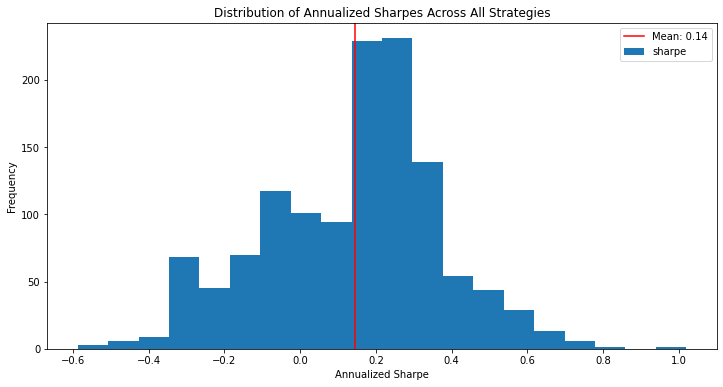

In [126]:
def plot_all_sharpes(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    (df_sharpe.sharpe.plot(
        ax     = axes,
        kind   = "hist",
        bins   = 20,
        xlabel = "Annualized Sharpe",
        title  = "Distribution of Annualized Sharpes Across All Strategies"))

    axes.axvline(
        x     = df_sharpe.sharpe.mean(),
        color = "red",
        label = "Mean: {}".format(round(df_sharpe.sharpe.mean(), 2)))

    axes.legend()
    
plot_all_sharpes(df_sharpe)

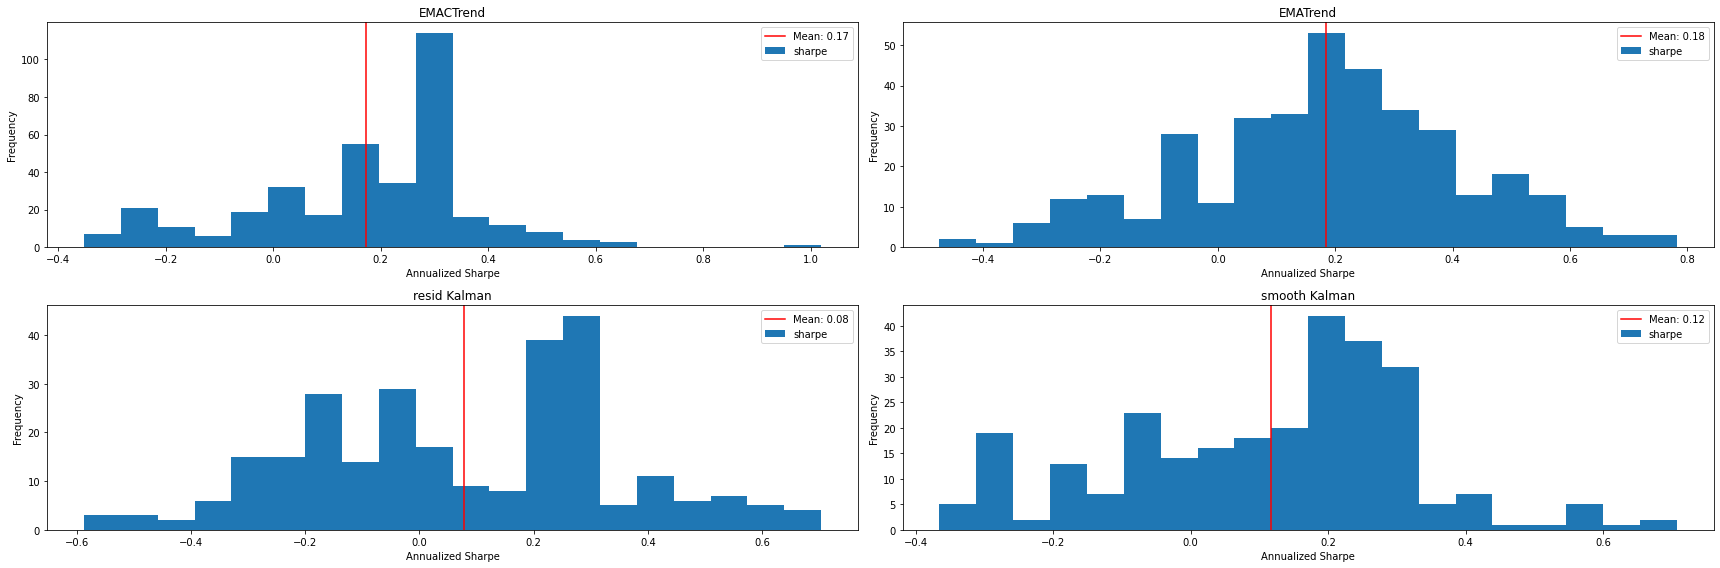

In [151]:
spef_col = "signal_type"

df_tmp    = df_sharpe.rename(columns = {spef_col: "tmp"})
tmps      = df_tmp.tmp.drop_duplicates().sort_values().to_list()
fig, axes = plt.subplots(ncols = len(tmps) // 2, nrows = len(tmps) // 2, figsize = (len(tmps) * 6, len(tmps) * 2))

for tmp, ax in zip(tmps, axes.flatten()): 
    
    df_plot = df_tmp.query("tmp == @tmp")
    (df_plot.sharpe.plot(
        ax     = ax,
        kind   = "hist",
        bins   = 20,
        xlabel = "Annualized Sharpe",
        title  = tmp))
    
    ax.axvline(
        x     = df_plot.sharpe.mean(),
        color = "red",
        label = "Mean: {}".format(round(df_plot.sharpe.mean(), 2)))
    
    ax.legend()
    
plt.tight_layout()

## Naive optimzer

Optimize per security

In [161]:
def get_namer(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_namer = (df.assign(
        full_name = lambda x: 
            x.variable.str.replace(" ", "-").str.replace("_", "-") + "_" + 
            x.strat_name + "_" + 
            x.signal_type.str.replace(" ", "-") + "_" + 
            x.security))
    
    return df_namer

df_namer = get_namer(df)

In [176]:
def _get_rolling_sharpe(df: pd.DataFrame, window: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(
            roll_sharpe     = lambda x: x.signal_rtn.rolling(window = window).mean() / x.signal_rtn.rolling(window = window).std() * np.sqrt(252),
            lag_roll_sharpe = lambda x: x.roll_sharpe.shift()).
        dropna())
    
    return df_out

def get_rolling_sharpe(df_namer: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_out = (df_namer.groupby(
        "full_name").
        apply(_get_rolling_sharpe, window).
        reset_index(drop = True))
    
    return df_out

df_roll_sharpe = get_rolling_sharpe(df_namer)

Now make decile buckets per each strat grouped by security full sample sharpe

In [207]:
def _decile_full_sample_sharpe(df: pd.DataFrame, d: int) -> pd.DataFrame:
    
    try:
        
        df_tmp = (df.assign(
            decile = lambda x: pd.qcut(x = x.sharpe, q = d, labels = ["D{}".format(i + 1) for i in range(d)])))        

        return df_tmp
        
    except: print("{} failed".format(df.name))

def decile_full_sample_sharpe(df_sharpe: pd.DataFrame, d: int = 10) -> pd.DataFrame: 

    df_decile = (df_sharpe.drop(
        columns = ["mean_rtn", "std_rtn"]).
        groupby("security").
        apply(_decile_full_sample_sharpe, d).
        reset_index(drop = True))
    
    return df_decile

df_decile = decile_full_sample_sharpe(df_sharpe)

UXY1 failed
WN1 failed


In [220]:
def preprocess(df_roll_sharpe: pd.DataFrame, df_decile: pd.DataFrame) -> pd.DataFrame: 
    
    df_prep = (df_roll_sharpe.merge(
        right = df_decile, how = "inner", on = ["variable", "strat_name", "signal_type", "security"]).
        assign(tmp_group = lambda x: x.security + " " + x.decile.astype(str)))
    
    return df_prep

df_prep = preprocess(df_roll_sharpe, df_decile)

In [234]:
def _max_sharpe(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.query(
        "lag_roll_sharpe == lag_roll_sharpe.max()").
        groupby("lag_roll_sharpe").
        head(1))

def _optimize(df: pd.DataFrame) -> pd.DataFrame:
    
    print("Working on {}".format(df.name))
    df_out = (df.groupby(
        "date").
        apply(_max_sharpe).
        reset_index(drop = True))
    
    return df_out

def optimize(df_prep: pd.DataFrame) -> pd.DataFrame:

    df_out = (df_prep.groupby(
        "tmp_group").
        apply(_optimize).
        reset_index(drop = True))
    
    return df_out

df_opt = optimize(df_prep)

Working on FV1 D1
Working on FV1 D10
Working on FV1 D2
Working on FV1 D3
Working on FV1 D4
Working on FV1 D5
Working on FV1 D6
Working on FV1 D7
Working on FV1 D8
Working on FV1 D9
Working on TU1 D1
Working on TU1 D10
Working on TU1 D2
Working on TU1 D3
Working on TU1 D4
Working on TU1 D5
Working on TU1 D6
Working on TU1 D7
Working on TU1 D8
Working on TU1 D9
Working on TY1 D1
Working on TY1 D10
Working on TY1 D2
Working on TY1 D3
Working on TY1 D4
Working on TY1 D5
Working on TY1 D6
Working on TY1 D7
Working on TY1 D8
Working on TY1 D9
Working on US1 D1
Working on US1 D10
Working on US1 D2
Working on US1 D3
Working on US1 D4
Working on US1 D5
Working on US1 D6
Working on US1 D7
Working on US1 D8
Working on US1 D9


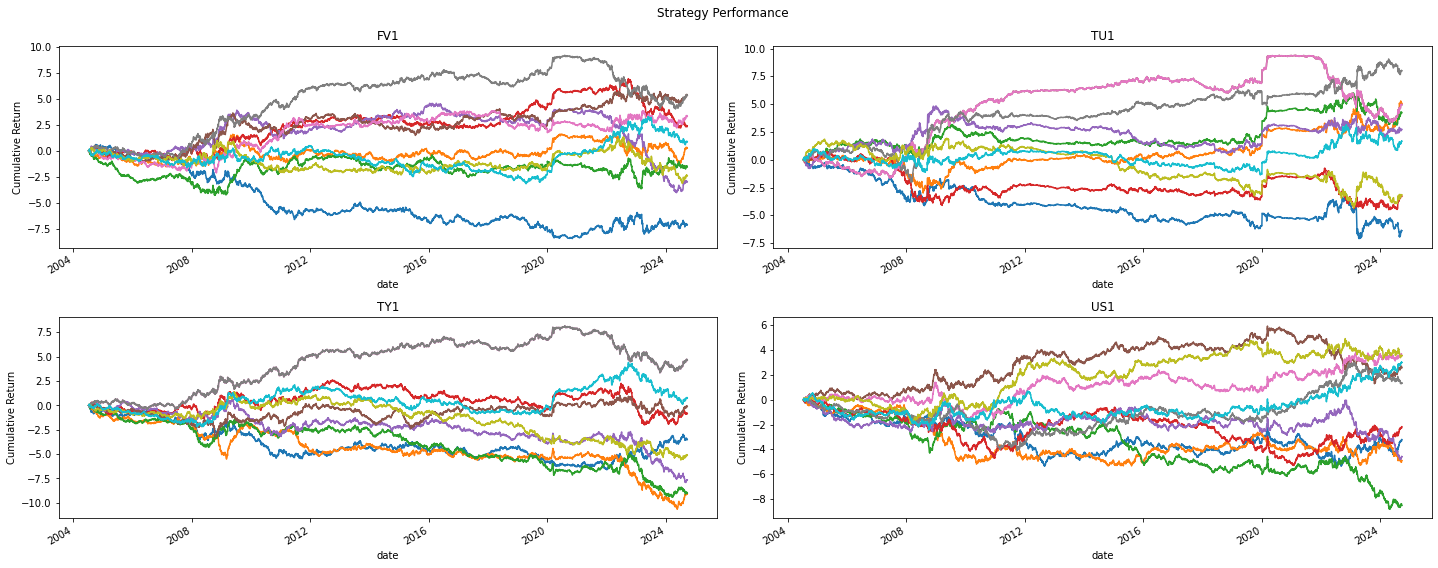

In [249]:
def plot_returns(df_opt: pd.DataFrame) -> plt.Figure: 
    
    securities = df_opt.security.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(securities) // 2, nrows = len(securities) // 2, figsize = (20,8))

    for security, ax in zip(securities, axes.flatten()):

        (df_opt.query(
            "security == @security")
            [["decile", "date", "signal_rtn"]].
            pivot(index = "date", columns = "decile", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                legend = False,
                title  = security,
                ylabel = "Cumulative Return"))


    fig.suptitle("Strategy Performance")
    plt.tight_layout()
    
plot_returns(df_opt)

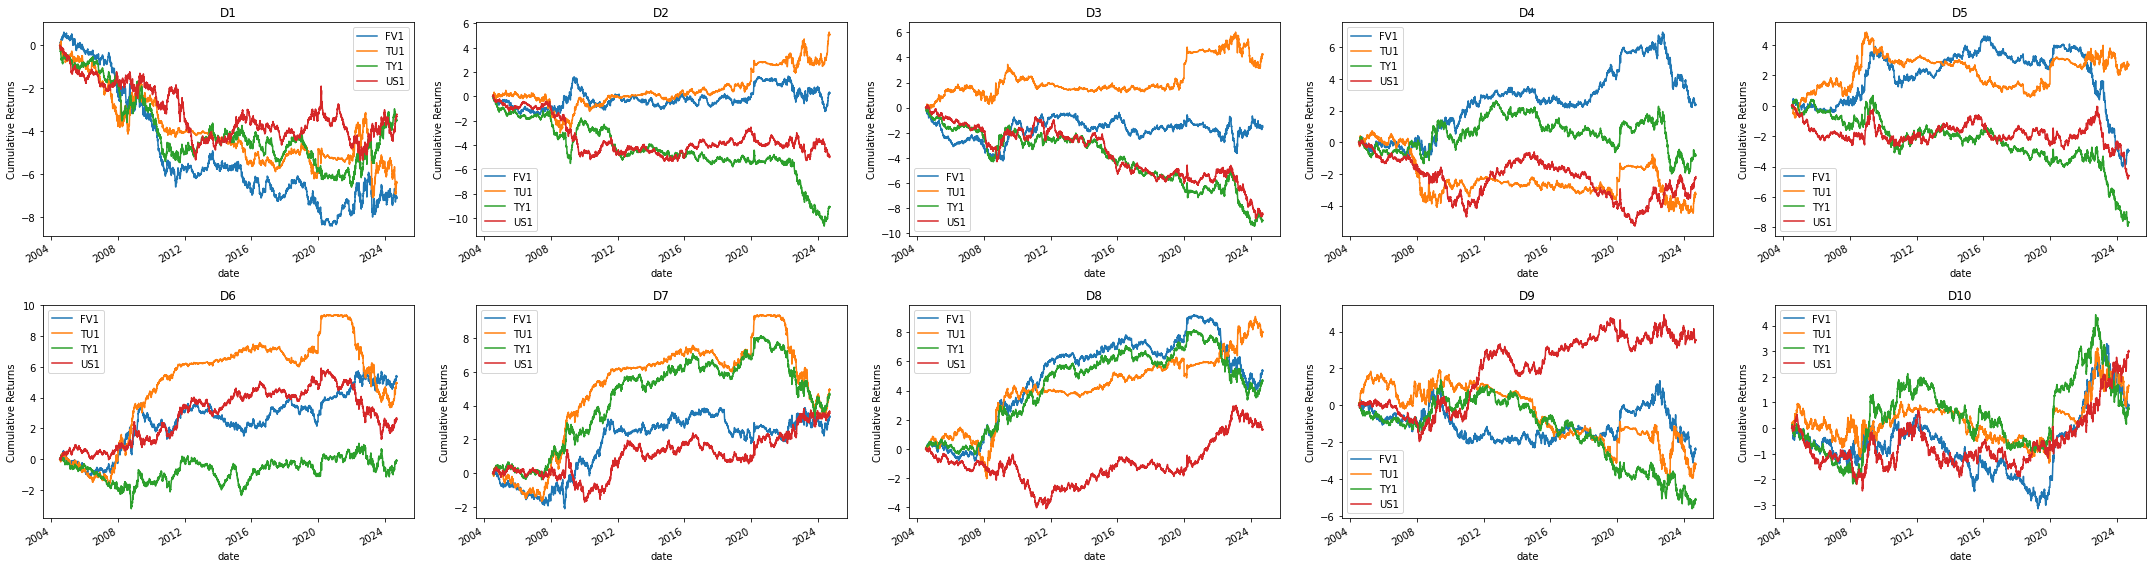

In [267]:
def plot_opt_port_by_decile(df_opt: pd.DataFrame) -> plt.Figure: 
    
    deciles   = df_opt.decile.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(deciles) // 2, nrows = len(deciles) // 5, figsize = (30,8))

    for decile, ax in zip(deciles, axes.flatten()):

        (df_opt.query(
            "decile == @decile")
            [["date", "security", "signal_rtn"]].
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative Returns",
                title  = decile))

    plt.tight_layout()
    
plot_opt_port_by_decile(df_opt)